# Table of contents
1. [Creating synthetic data](#Creating-synthetic-data)
2. [Set up network](#Set-up-network)
3. [Subsetting data](#Subsetting-data)
4. [Noise](#Noise)
5. [SoftAdapt](#SoftAdapt)

In [1]:
import deepxde as dde
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt
import numpy as np

import os
os.chdir('exercises_Jakob')

from SIRD_deepxde_DiseaseModel import SIRD_deepxde_net
from DiseaseModel import SIR,SIRD, SIRDn,SIRDIm,SIRImRel, SIRDImRel, SIRD2Var, SIRD2VarRelSimple, GeneralModelSolver
import Plot
from importlib import reload

reload(Plot)
Plot = Plot.Plot

seed = 2
np.random.seed(seed)
dde.config.set_random_seed(seed)

Using backend: pytorch



In [84]:
def plot_result_single(model, figsize=(8,4), dpi=300, lw=2):
    model_plot = Plot(model)

    fig, ax = plt.subplots(1,1, figsize=figsize, dpi=dpi)
    for i, label in enumerate(model_plot.sird_values_to_plot):
        if "Im" in label:
            continue
        try:
            # line, = ax.plot(self.model.t, self.model.wsol[:,i], color=f"C{i}", ls='-',marker='',markersize=1, lw=1.8, alpha=0.5)
            line, = ax.plot(model_plot.model.t, model_plot.model.wsol[:,i], color=f"C{i}", ls='-', alpha=0.5, lw=lw)
        except:
            print(f"No synthetic data in {label} to plot")
        line.set_label(label+' train')

    for i, label in enumerate(model_plot.values_to_plot):
        line, = ax.plot(model_plot.model.t_nn_best, model_plot.model.wsol_nn_best[:,i], linestyle='--', color=f"C{i}", lw=lw)#, label=f"{label} Prediction")

    line.set_label('PINN prediction')

    ax.set_title('PINN prediction')
    ax.set_ylabel('Number of people')
    ax.set_xlabel('Time [day]')
    ax.legend()

    return fig, ax


def plot_result(model, xcut=None, xcut_label=None, figsize=(8,4), dpi=300, lw=2):
    model_plot = Plot(model)

    fig, axes = plt.subplots(2,1, figsize=figsize, sharey=True, dpi=dpi)
    axes.flatten()
    ax = axes[0]
    for i, label in enumerate(model_plot.sird_values_to_plot):
        if "Im" in label:
            continue
        try:
            # line, = ax.plot(self.model.t, self.model.wsol[:,i], color=f"C{i}", ls='-',marker='',markersize=1, lw=1.8, alpha=0.5)
            line, = ax.plot(model_plot.model.t, model_plot.model.wsol[:,i], color=f"C{i}", ls='-', alpha=0.5,lw=lw)
        except:
            print(f"No synthetic data in {label} to plot")
        line.set_label(label+' train')

    for i, label in enumerate(model_plot.values_to_plot):
        line, = ax.plot(model_plot.model.t_nn_best, model_plot.model.wsol_nn_best[:,i], linestyle='--', color=f"C{i}",lw=lw)#, label=f"{label} Prediction")

    line.set_label('PINN\nprediction')

    ax.set_title('PINN prediction')
    ax.set_ylabel('Number of people')
    #ax.set_xlabel('Time [day]')
    ax.legend()

    ax = axes[1]
    if xcut is not None:
        ax.vlines(x=xcut, ymin=0,ymax=1e6,label=xcut_label,color='black',linestyle='--',lw=1)
    
    #model_plot.plot_future_prediction(axes[1])
    for i, label in enumerate(model_plot.values_to_plot):
        line = ax.plot(model.t_synth, model.wsol_synth[:,i], linestyle='-', color=f"C{i}", lw=1.8, alpha=0.5
                      # , label=label
                      )
    
    for i, label in enumerate(model_plot.values_to_plot):
        line, = ax.plot(model.t_nn_synth, model.wsol_nn_synth[:,i], linestyle='--', color=f"C{i}")
    line.set_label('Param\nprediction')
    
    
    ax.set_title('Solving ODE with PINN parameters')
    ax.set_xlabel('Time [day]')
    ax.set_ylabel('Number of people')
    ax.legend()
    
    plt.subplots_adjust(wspace=0.05, hspace=0)
    return fig, axes

# Creating synthetic data <a name="Creating-synthetic-data"></a>
Synthetic data is created using SIR class (in DiseaseModel script)

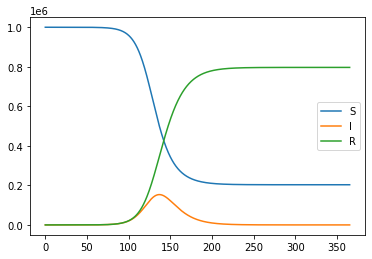

In [24]:
time_delta = [0,365] # use three values here for intro time of second variant


initial_conditions = {
    "S": 1000000,
    "I": 1,
    "R": 0,
    #"D": 0,
    }
static_parameters = {
    "alpha": 0.2,
    "beta": 0.1,
    #"gamma": 0.00,
    }
sird_model = SIR(initial_conditions, static_parameters, time_delta)


t_synth, solution_synth = sird_model.simulate(numpoints=365*4)
t_synth = np.array(t_synth)
sird_model.plot_sird()
t = t_synth
wsol = solution_synth

sird_model.add_solver(GeneralModelSolver)

# Set up network <a name="Set-up-network"></a>
Network is saved in SIRD_deepxde_net class (in SIRD_deepxde_DiseaseModel script). This uses the deepxde library.

In [4]:
model = SIRD_deepxde_net(t, wsol, disease_model=sird_model,  model_name="diseasemodel_simulated_data", with_softadapt=False,
                        with_neumann=False, # important for peak prediction
                        use_ln_space=False,
                        use_ic_loss=True,
                        use_observe_loss=True,
                        use_observe_I_loss=False,
                        use_observe_sum_loss=False,
                        use_sign_loss=False,
                        use_smooth_loss=False,
                        use_initL1_loss=False,
                        use_infectedL1_loss=False,)

model.set_synthetic_data(t_synth, solution_synth)

hyper_print_every = 15000
static_loss_weights = []
for key in (model.PDE_names + list(model.loss_points_dict.keys())):
    w = 1
    static_loss_weights.append(w)
model.init_model(lr=0.01, print_every=hyper_print_every, activation="tanh", loss="MSE", nn_layers=2, nn_layer_width=32, loss_weights=static_loss_weights)

Compiling model...
'compile' took 0.000193 s



### Train network

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.25e-03, 9.53e-04, 5.78e-04, 0.00e+00, 0.00e+00, 1.00e-01, 4.84e-02, 3.94e-03, 8.99e-03]    [3.25e-03, 9.53e-04, 5.78e-04, 0.00e+00, 0.00e+00, 1.00e-01, 4.84e-02, 3.94e-03, 8.99e-03]    []  
15000     [5.80e-07, 2.54e-07, 4.79e-07, 3.95e-07, 1.10e-09, 8.74e-09, 6.32e-06, 1.75e-06, 5.39e-06]    [5.80e-07, 2.54e-07, 4.79e-07, 3.95e-07, 1.10e-09, 8.74e-09, 6.32e-06, 1.75e-06, 5.39e-06]    []  

Best model at step 11286:
  train loss: 7.21e-07
  test loss: 7.21e-07
  test metric: []

'train' took 280.538857 s

Best train step: 11286
alpha: 0.19999685884
beta: 0.10010865331
{'alpha': 0.2, 'beta': 0.1}


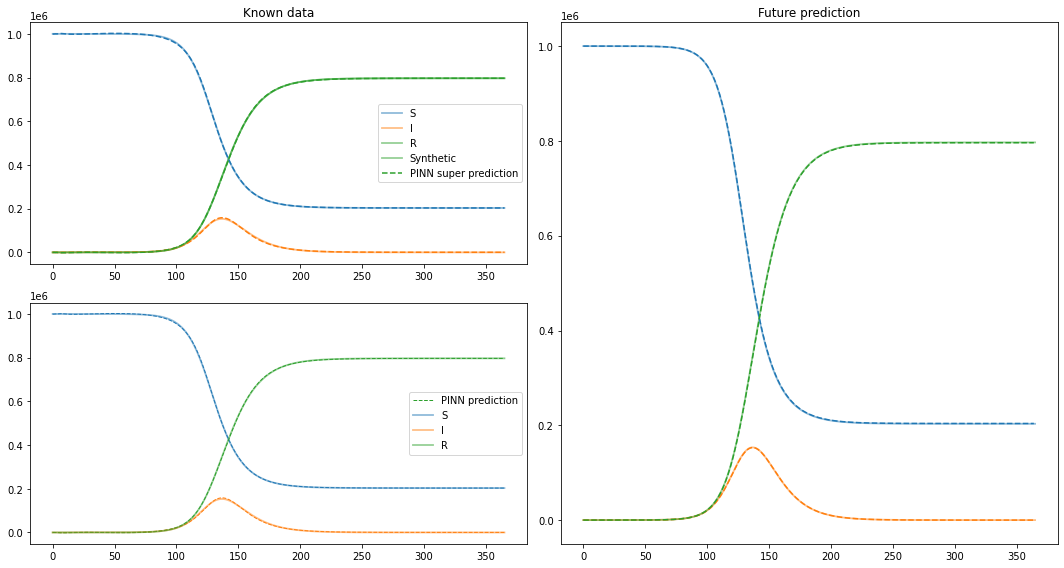

In [5]:
model.intermediate_train(reset=True)

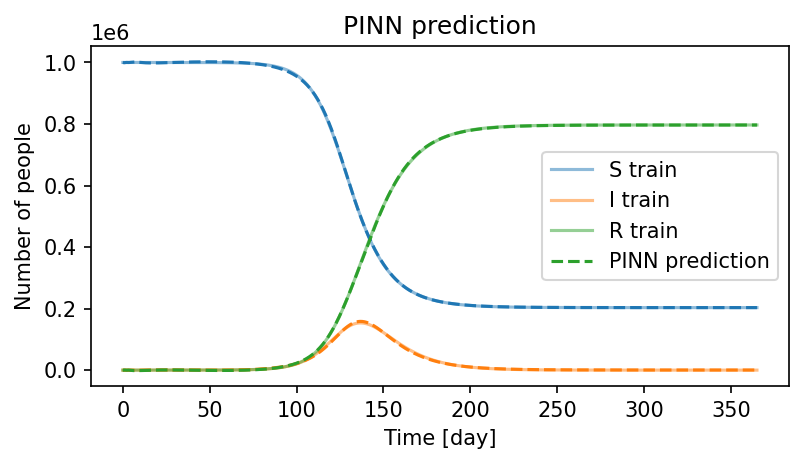

In [6]:
fig, axes = plot_result_single(model, figsize=(6,3), dpi=150, lw=1.5)
plt.savefig('figures/peak_pred_all_t.png',format='png',bbox_inches='tight')

# Subsetting data <a name="Subsetting-data"></a>
Select only data before $t\leq125$ to do peak prediction.

In [25]:
t_125_bool = t <= 125
t_125 = t[t_125_bool]
wsol_125 = wsol[t_125_bool]

In [8]:
model_125 = SIRD_deepxde_net(t_125, wsol_125, disease_model=sird_model,  model_name="diseasemodel_simulated_data_150", with_softadapt=False,
                        with_neumann=False, # important for peak prediction
                        use_ln_space=False,
                        use_ic_loss=True,
                        use_observe_loss=True,
                        use_observe_I_loss=False,
                        use_observe_sum_loss=False,
                        use_sign_loss=False,
                        use_smooth_loss=False,
                        use_initL1_loss=False,
                        use_infectedL1_loss=False,)

model_125.set_synthetic_data(t_synth, solution_synth)

hyper_print_every = 250000
static_loss_weights = []
for key in (model_125.PDE_names + list(model_125.loss_points_dict.keys())):
    w = 1
    if "d" in key and "_t" in key:
        w = 2
    elif "observe_I" in key:
        w = 0.1
    elif "ic" in key:
        w = 0.1
    else:
        w = 0.1
    static_loss_weights.append(w)
model_125.init_model(lr=0.01, print_every=hyper_print_every, activation="tanh", loss="MSE", nn_layers=2, nn_layer_width=32, loss_weights=static_loss_weights)

Compiling model...
'compile' took 0.000119 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.17e-04, 1.62e-03, 4.70e-03, 0.00e+00, 0.00e+00, 1.00e-01, 1.69e-01, 2.11e-03, 4.19e-02]    [5.17e-04, 1.62e-03, 4.70e-03, 0.00e+00, 0.00e+00, 1.00e-01, 1.69e-01, 2.11e-03, 4.19e-02]    []  
250000    [3.19e-06, 7.19e-07, 8.99e-07, 3.01e-06, 1.13e-06, 1.14e-06, 2.16e-06, 4.27e-06, 1.46e-06]    [3.19e-06, 7.19e-07, 8.99e-07, 3.01e-06, 1.13e-06, 1.14e-06, 2.16e-06, 4.27e-06, 1.46e-06]    []  

Best model at step 84274:
  train loss: 1.96e-07
  test loss: 1.96e-07
  test metric: []

'train' took 2658.368981 s

Best train step: 84274
alpha: 0.19769327343
beta: 0.098556563258
{'alpha': 0.2, 'beta': 0.1}


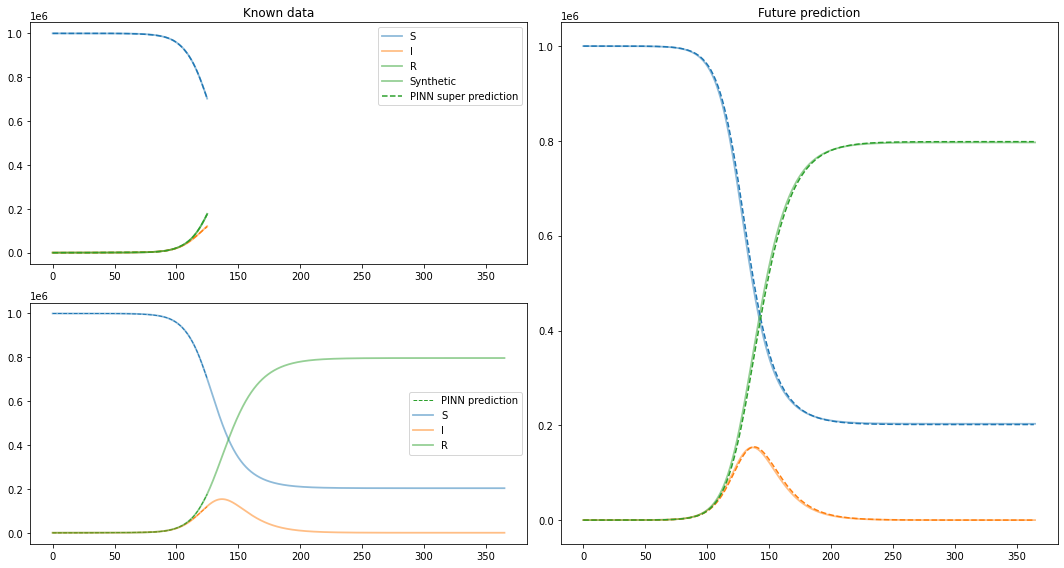

In [9]:
model_125.intermediate_train(reset=True)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
250000    [3.19e-06, 7.19e-07, 8.99e-07, 3.01e-06, 1.13e-06, 1.14e-06, 2.16e-06, 4.27e-06, 1.46e-06]    [3.19e-06, 7.19e-07, 8.99e-07, 3.01e-06, 1.13e-06, 1.14e-06, 2.16e-06, 4.27e-06, 1.46e-06]    []  
500000    [3.41e-06, 7.83e-07, 1.01e-06, 2.43e-06, 5.47e-07, 8.81e-09, 4.64e-07, 2.05e-06, 4.76e-07]    [3.41e-06, 7.83e-07, 1.01e-06, 2.43e-06, 5.47e-07, 8.81e-09, 4.64e-07, 2.05e-06, 4.76e-07]    []  

Best model at step 84274:
  train loss: 1.96e-07
  test loss: 1.96e-07
  test metric: []

'train' took 2646.238642 s

Best train step: 84274
alpha: 0.19769327343
beta: 0.098556563258
{'alpha': 0.2, 'beta': 0.1}


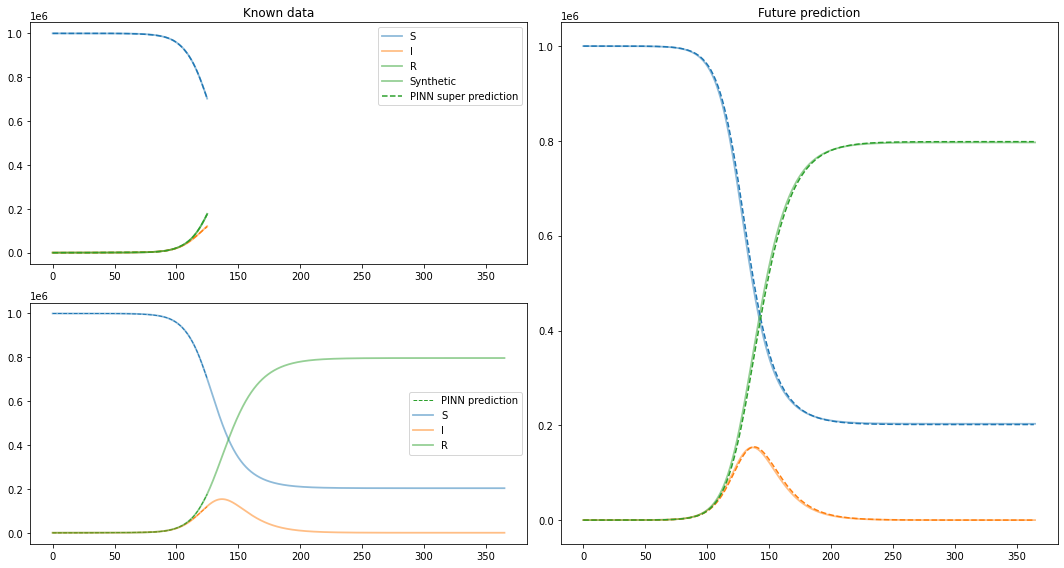

In [10]:
model_125.intermediate_train()

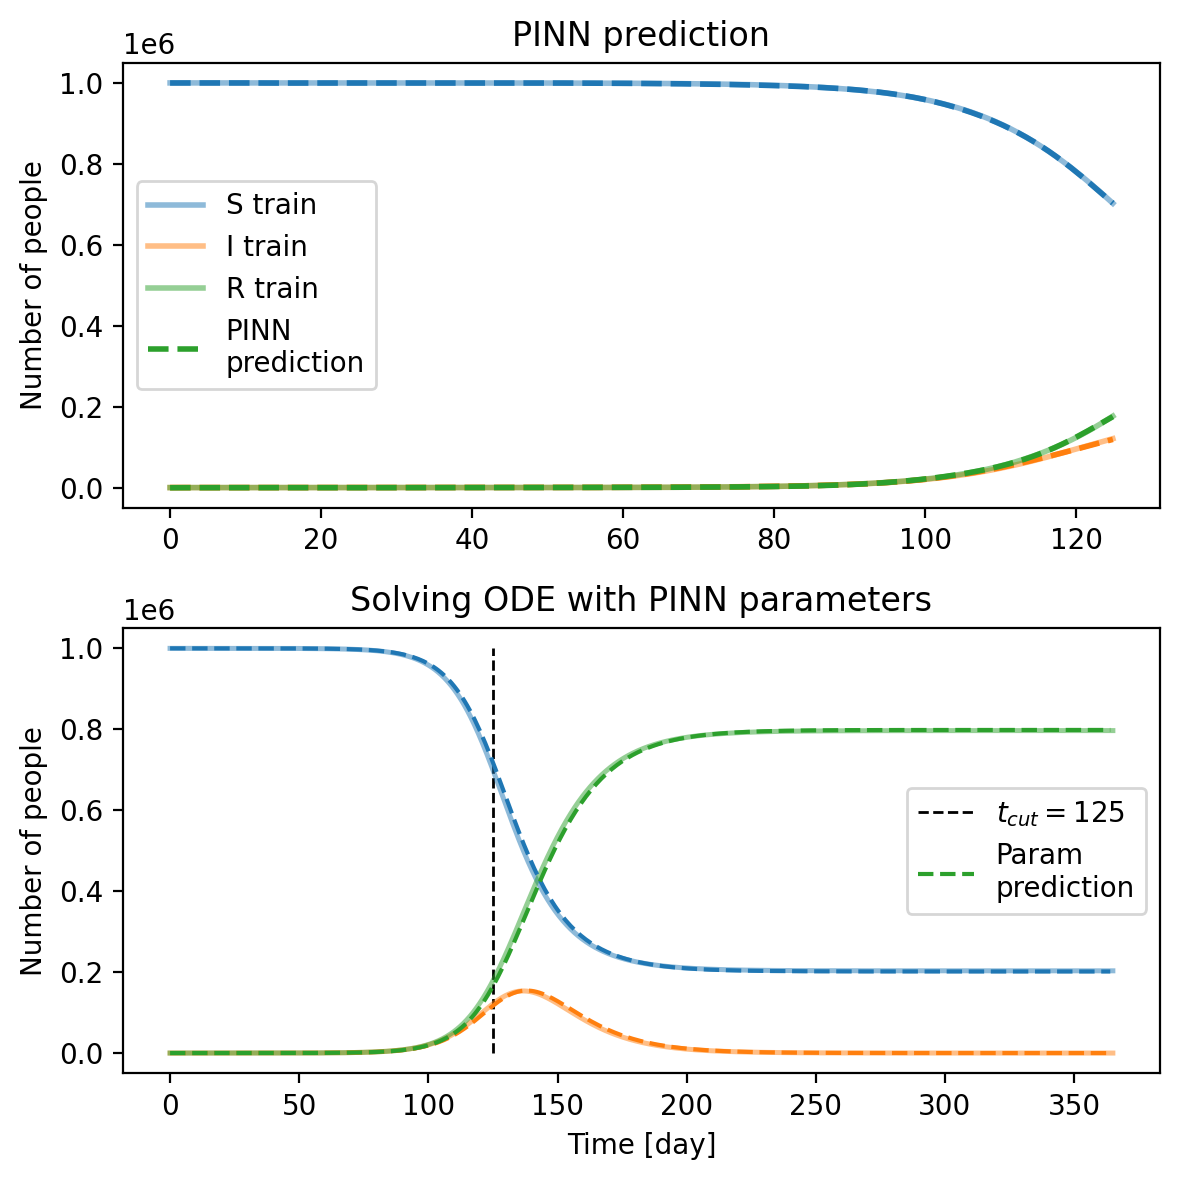

In [85]:
fig, axes = plot_result(model_125 ,xcut=125, xcut_label='$t_{cut}=125$', figsize=(6,6), dpi=200, lw=2)
plt.tight_layout()
plt.savefig('figures/peak_pred_125_t.png',format='png',bbox_inches='tight')

# Noise <a name="Noise"></a>
Add noise to the data and train network

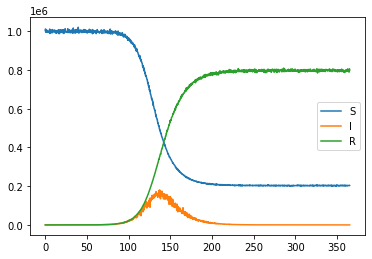

In [12]:
solution_synth = solution_synth.copy()
solution_synth[:,0] = solution_synth[:,0] + np.random.normal(loc=0, scale=solution_synth[:,0]*0.005)
solution_synth[:,1] = solution_synth[:,1] + np.random.normal(loc=0, scale=solution_synth[:,1]*0.1) 
solution_synth[:,2] = solution_synth[:,2] + np.random.normal(loc=0, scale=solution_synth[:,2]*0.005)

sird_model.solution_sird = solution_synth
sird_model.plot_sird()

t = t_synth
wsol = solution_synth

In [13]:
model_noise = SIRD_deepxde_net(t, wsol, disease_model=sird_model,  model_name="diseasemodel_simulated_data_noise_manual", with_softadapt=False,
                        with_neumann=False, # important for peak prediction
                        use_ln_space=False,
                        use_ic_loss=True,
                        use_observe_loss=True,
                        use_observe_I_loss=False,
                        use_observe_sum_loss=False,
                        use_sign_loss=False,
                        use_smooth_loss=False,
                        use_initL1_loss=False,
                        use_infectedL1_loss=False,)

model_noise.set_synthetic_data(t_synth, solution_synth)

hyper_print_every = 15000
model_noise.hyper_print_every = hyper_print_every

static_loss_weights = []
for key in (model_noise.PDE_names + list(model_noise.loss_points_dict.keys())):
    w = 1
    if "d" in key and "_t" in key:
        w = 2
    elif "observe_I" in key:
        w = 0.1
    elif "ic" in key:
        w = 0.1
    else:
        w = 0.1
    static_loss_weights.append(w)
model_noise.init_model(lr=0.01, print_every=hyper_print_every, activation="tanh", loss="MSE", nn_layers=2, nn_layer_width=32, loss_weights=static_loss_weights)

Compiling model...
'compile' took 0.000114 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [7.86e-02, 1.73e-02, 2.15e-02, 0.00e+00, 0.00e+00, 1.00e-01, 6.97e-02, 1.11e-01, 1.29e-02]    [7.86e-02, 1.73e-02, 2.15e-02, 0.00e+00, 0.00e+00, 1.00e-01, 6.97e-02, 1.11e-01, 1.29e-02]    []  
15000     [1.32e-06, 4.59e-07, 8.72e-07, 2.30e-07, 1.03e-07, 1.19e-08, 1.13e-05, 5.00e-06, 1.06e-05]    [1.32e-06, 4.59e-07, 8.72e-07, 2.30e-07, 1.03e-07, 1.19e-08, 1.13e-05, 5.00e-06, 1.06e-05]    []  

Best model at step 10135:
  train loss: 3.93e-06
  test loss: 3.93e-06
  test metric: []

'train' took 257.923447 s

Best train step: 10135
alpha: 0.1942627579
beta: 0.09704592824
{'alpha': 0.2, 'beta': 0.1}


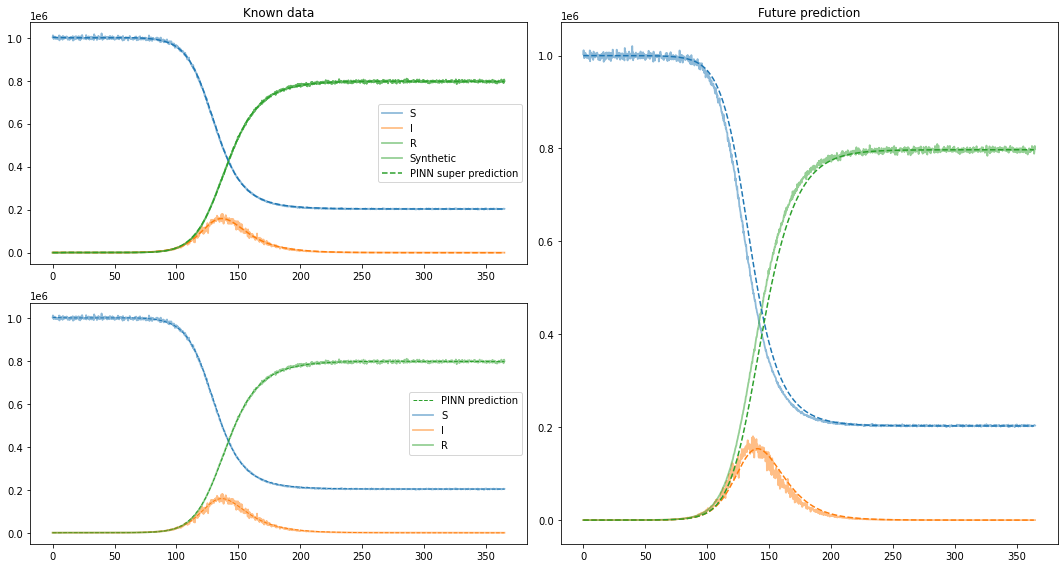

In [14]:
model_noise.intermediate_train(reset=True)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
15000     [1.32e-06, 4.59e-07, 8.72e-07, 2.30e-07, 1.03e-07, 1.19e-08, 1.13e-05, 5.00e-06, 1.06e-05]    [1.32e-06, 4.59e-07, 8.72e-07, 2.30e-07, 1.03e-07, 1.19e-08, 1.13e-05, 5.00e-06, 1.06e-05]    []  
30000     [4.46e-07, 2.92e-07, 4.16e-07, 7.53e-10, 2.73e-09, 2.45e-09, 7.68e-06, 3.86e-06, 7.27e-06]    [4.46e-07, 2.92e-07, 4.16e-07, 7.53e-10, 2.73e-09, 2.45e-09, 7.68e-06, 3.86e-06, 7.27e-06]    []  

Best model at step 16451:
  train loss: 3.86e-06
  test loss: 3.86e-06
  test metric: []

'train' took 249.657365 s

Best train step: 16451
alpha: 0.1991353482
beta: 0.098776593804
{'alpha': 0.2, 'beta': 0.1}


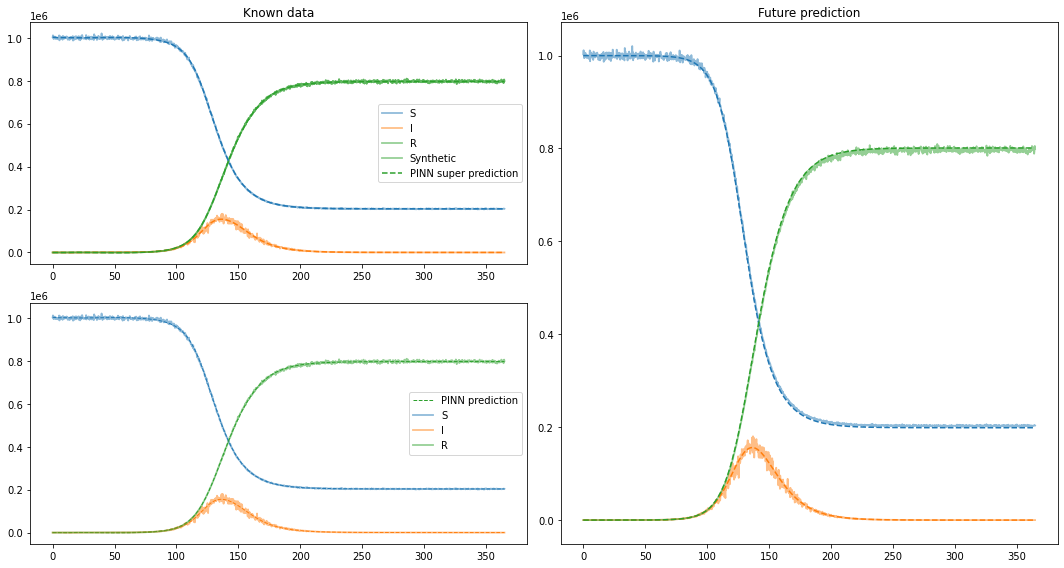

In [32]:
model_noise.intermediate_train()

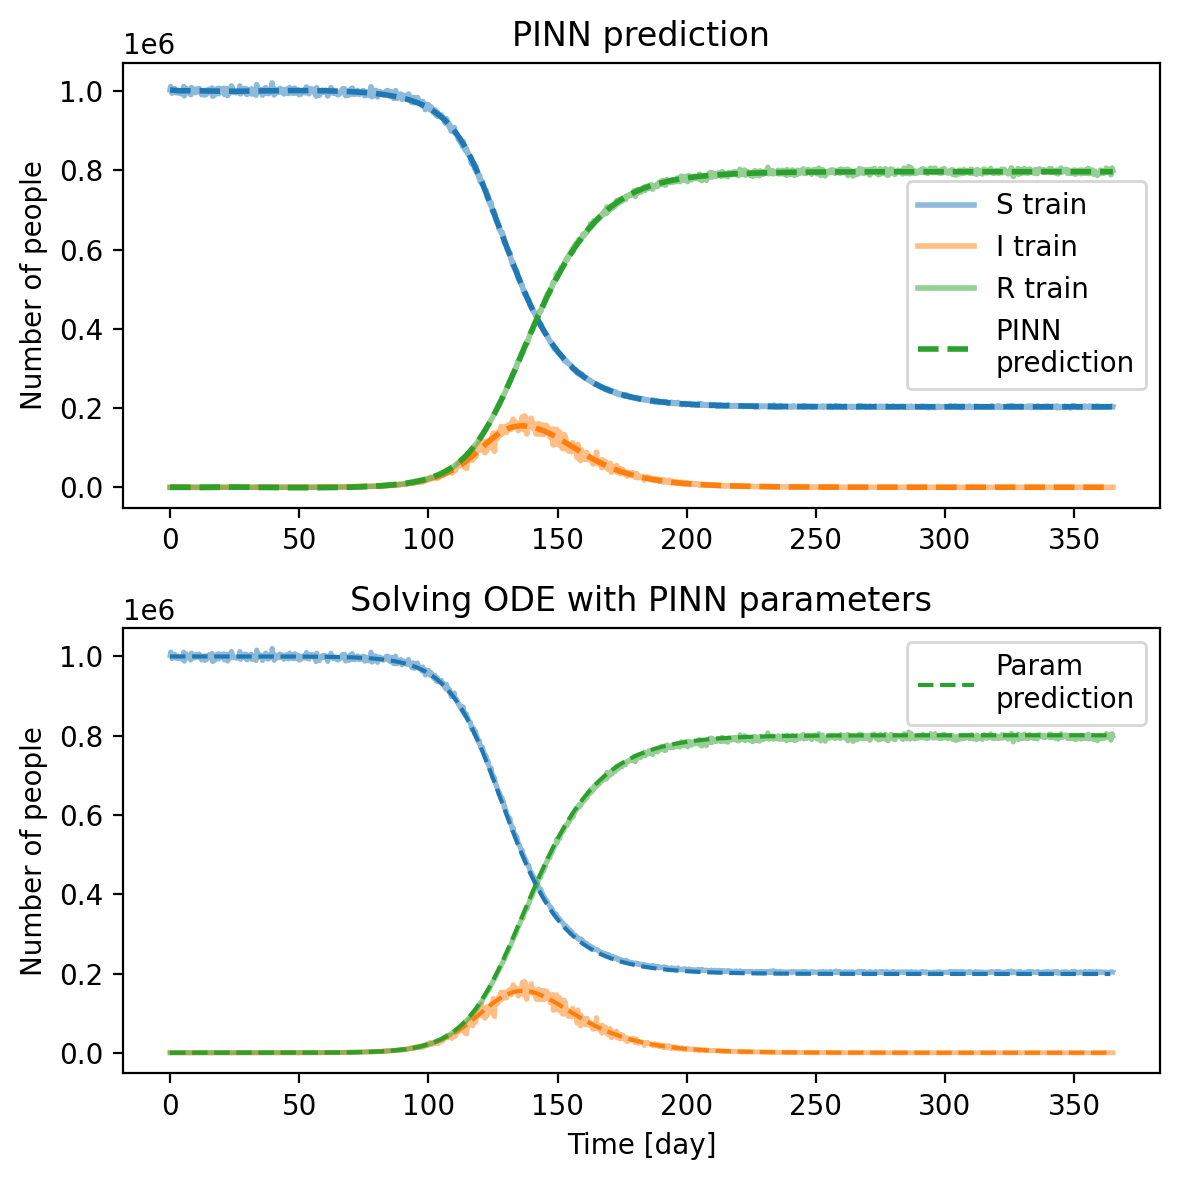

In [87]:
fig, axes = plot_result(model_noise, figsize=(6,6), dpi=200, lw=2)
plt.tight_layout()
plt.savefig('figures/pp_noise.png',format='png')

# SoftAdapt <a name="SoftAdapt"></a>
To implement the SoftAdapt algorithm properly it was easier to implement the PINN in PyTorch.

In [45]:
import numpy as np
import torch

from torch import nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

### Class to solve SIR 
(Slightly modified compared to model used earlier - just added option to reduce number of points)

In [46]:
class SIRD:
    def __init__(self):
       pass

    def vectorfield(self, w, t, p):
        """
        Defines the differential equations for the coupled spring-mass system.

        Arguments:
            w :  vector of the state variables:
                    w = [x1,y1,x2,y2]
            t :  time
            p :  vector of the parameters:
                    p = [m1,m2,k1,k2,L1,L2,b1,b2]
        """
        S, I, R = w
        alpha, beta = p
       
        f = [ - alpha/(self.N) * I  * S,
            (alpha/(self.N)) * S * I - beta * I,
            beta * I
            ]
        
        return f

    def solve_SIRD(self, s, div_num_points=1):
        # Initial conditions
        S, I, R = s['S'], s['I'],  s['R']
        
        alpha = s['alpha']
        beta = s['beta']
        
        self.N = S + I + R# + D
        
        # ODE solver parameters
        abserr = 1.0e-8
        relerr = 1.0e-6
        stoptime = 600.0
        numpoints = int(stoptime/div_num_points)
        t = np.linspace(0, stoptime, numpoints, endpoint=True)
        p = [alpha, beta]
        w0 = [S, I, R]
        
        # Call the ODE solver.
        wsol = odeint(self.vectorfield, w0, t, args=(p,),
                      atol=abserr, rtol=relerr)
        return t, wsol, self.N
    
    def plot_SIRD(self, t, wsol, ax=None, title=None,set_xlabel=True):
        if ax is None:
            fig, ax = plt.subplots()
        
        S = wsol[:,0]
        I = wsol[:,1]
        R = wsol[:,2]
        
        ax.scatter(t, S, label='S', color='C0')
        ax.scatter(t, I, label='I',color='C1')        
        ax.scatter(t, R, label='R',color='C2')
        
        ax.legend()
        ax.grid(linestyle=':') #
        ax.set_axisbelow(True)
        if title is not None:
            ax.set_title(title)
        if set_xlabel:
            ax.set_xlabel('Time [day]')
        ax.set_ylabel('Number of people')

### PyTorch implementation of the SIR PINN

In [47]:
def calc_grad(inp, out):
    return grad(out, inp, 
                grad_outputs = torch.ones_like(out),
                create_graph=True)[0]

class Net(nn.Module):

    def __init__(self, num_hidden, num_features, num_output, num_hidden_layers):
        super(Net, self).__init__()  
        self.num_hidden_layers = num_hidden_layers
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        
        for i in range(self.num_hidden_layers):
            x = F.linear(x, self.W_2, self.b_2)
            x = self.activation(x)
        
        x = F.linear(x, self.W_3, self.b_3)
        return x

class SIRD_net:
    def __init__(self, t, wsol, t_pde, init_num_people, parameters, epochs=50000):
        self.epochs = epochs
        
        self.parameters = {}
        self.param_values = {}
        for parameter, val in parameters.items():
            self.parameters[parameter] = nn.Parameter(torch.tensor([val], requires_grad=True).float() )
            self.param_values[parameter] = np.full(epochs, np.nan)
        
        self.t = torch.tensor(t, requires_grad=True).reshape(len(t),1).float()
        self.t_pde = torch.tensor(t_pde, requires_grad=True).reshape(len(t_pde),1).float()
        self.init_num_people = torch.tensor(init_num_people).float()
        
        sol = wsol / init_num_people
        sol = np.c_[sol,sol.sum(axis=1)]
        
        self.sol = torch.tensor(sol, requires_grad=True).float()
        
        self.num_losses = 6
        self.lambdas = np.ones(self.num_losses)
        
        self.true_loss_values = np.full((epochs, len(self.lambdas)),np.nan)
        self.weighted_loss_values = np.full((epochs, len(self.lambdas)),np.nan)
        
        self.lambda_values = np.full((epochs, len(self.lambdas)),np.nan)
        self.max_loss = np.inf
    
    def pde(self, y):
        S, I = y[:,0], y[:,1]
        
        alpha = self.parameters['alpha']
        beta = self.parameters['beta']
        
        return [-(alpha * I )*S,
                alpha * I* S - beta * I,
                beta * I
                ]
    
    def softadapt(self, epoch, losses, loss_weighted=False, normalized=False):
        n = 50
        beta = 0.1
        eps = 1e-8
        if epoch < n:
            return np.ones(self.num_losses)
        
        nums = []

        for i in range(len(losses)):
            prev_losses = self.true_loss_values[epoch-n:epoch, i]
            loss_vec = np.append(prev_losses,float(losses[i]))
            
            si = loss_vec[1:] - loss_vec[:-1]
            if normalized:
                si /= (abs(si).sum() + eps)
                
            si_max = max(si)
            
            alpha = np.exp(beta*(si[-1] - si_max))
            nums.append(alpha)
            
        denom = sum(nums)+eps
        alphas = [x/denom for x in nums]
        
        if loss_weighted:
            nums = []
            for i in range(len(losses)):
                # f = losses[i]
                prev_losses = self.true_loss_values[epoch-n:epoch, i]
                loss_vec = np.append(prev_losses,float(losses[i]))
                f = loss_vec.mean()
                
                alpha = alphas[i]
                new_alpha = f*alpha
                nums.append(new_alpha)
            
            denom = sum(nums) + eps
            alphas = [x/denom for x in nums]
        
        return alphas
    
    def train(self, with_softadapt=False, loss_weighted=False, normalized=False):
        num_hidden, num_features, num_output = 20, 1, 3
        num_hidden_layers = 2

        self.net = Net(num_hidden, num_features, num_output, num_hidden_layers)
        t_train = self.t
        t_pde_train = self.t_pde

        lr = 0.0001
        params = [x for x in self.parameters.values()]
        optimizer = optim.Adam([{'params':self.net.parameters()},
                                {'params':params, 'lr':0.0001}], lr=lr)
        
        criterion = nn.MSELoss()
        
        self.losses = []
        for epoch in range(self.epochs):
            # Forward -> Backprob -> Update params
            ## Train
            self.net.train()
            optimizer.zero_grad()
    
            y = self.net(t_train)
            
            ### Target losses
            losses = []
            losses.append(criterion(y[:,0], self.sol[:,0])*100) 
            losses.append(criterion(y[:,1], self.sol[:,1])*100)
            losses.append(criterion(y[:,2], self.sol[:,2])*100)
            
            ### PDE losses
            pde_y = self.net(t_pde_train)
            
            diffs = []
            for i in range(pde_y.shape[1]):
                diffs.append(calc_grad(t_pde_train, pde_y[:,i]).flatten())
            
            pde_sol = self.pde(pde_y)
            
            for i in range(pde_y.shape[1]):
                loss = criterion(diffs[i], pde_sol[i])*100
                losses.append(loss)
            
            ### Reweight losses using softadapt
            if with_softadapt:
                alphas = self.softadapt(epoch, losses, loss_weighted=loss_weighted, normalized=normalized)
                for i in range(len(losses)):
                    self.true_loss_values[epoch, i] = losses[i]
                    loss = losses[i] * alphas[i]
                    losses[i] = loss
                    self.weighted_loss_values[epoch, i] = loss
                    self.lambda_values[epoch, i] = alphas[i]
            
            ### Sum up losses
            batch_loss = 0
            for loss in losses:
                batch_loss += loss
            
            batch_loss.backward()
            
            optimizer.step()
            
            self.losses.append(batch_loss)
            
            if not with_softadapt:
                for i in range(len(losses)):
                    self.true_loss_values[epoch, i] = losses[i]
                
            for param, val in self.parameters.items():
                self.param_values[param][epoch] = float(val.data)
        
            if batch_loss < self.max_loss:
                self.net.eval()
                self.best_prediction = self.net(t_train)
                self.best_epoch = epoch
                self.max_loss = batch_loss
            
            if epoch%20000==0 and epoch != 0:
                print("Epoch %2i : Train Loss %f" % (
                    epoch+1, self.true_loss_values[epoch, :].sum()))
                # print("\t",[round(float(x.data),5) for x in self.true_loss_values[epoch, :]])
                print("\t",[round(x,5) for x in self.true_loss_values[epoch, :]])
                print("\t",[round(x,5) for x in self.lambda_values[epoch, :]])
                print('')

### Create train data

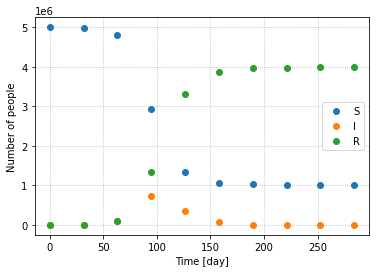

In [48]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

s = {'S':5000000,
     'I':200,
     'R':0,

     'alpha':0.2,
     'beta':0.1
     }


solver = SIRD()

t, wsol, N = solver.solve_SIRD(s, div_num_points=30)
t_bool = t < 300
t, wsol = t[t_bool], wsol[t_bool]
t_pde = np.linspace(0, t.max(),100)

S, I, R = wsol[:,0], wsol[:,1], wsol[:,2]
sird = np.c_[S,I,R]

solver.plot_SIRD(t, wsol)

### Train networks
one with equally weighted loss term and the other using SoftAdapt

In [49]:
fig_save_name = ''
    
parameters = {'alpha':0.5,
              'beta':0.25,
              }

t_train, sird_train = t, sird

epochs = 220000
epochs_softadapt = 150000

net = SIRD_net(t_train, sird_train, t_pde, N, parameters, epochs=epochs)
net.train()

net_softadapt = SIRD_net(t_train, sird_train, t_pde, N, parameters, epochs=epochs_softadapt)
net_softadapt.train(with_softadapt=True, loss_weighted=True, normalized=True)

Epoch 20001 : Train Loss 0.003248
	 [0.00012, 0.00077, 0.0015, 0.00028, 0.00015, 0.00042]
	 [nan, nan, nan, nan, nan, nan]

Epoch 40001 : Train Loss 0.000242
	 [1e-05, 0.0001, 2e-05, 5e-05, 2e-05, 4e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 60001 : Train Loss 0.000160
	 [1e-05, 8e-05, 1e-05, 3e-05, 2e-05, 2e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 80001 : Train Loss 0.000125
	 [1e-05, 6e-05, 1e-05, 2e-05, 1e-05, 2e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 100001 : Train Loss 0.000501
	 [1e-05, 0.00037, 8e-05, 2e-05, 1e-05, 2e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 120001 : Train Loss 0.000082
	 [0.0, 4e-05, 0.0, 1e-05, 1e-05, 1e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 140001 : Train Loss 0.000086
	 [0.0, 5e-05, 1e-05, 1e-05, 1e-05, 1e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 160001 : Train Loss 0.000056
	 [0.0, 3e-05, 0.0, 1e-05, 0.0, 1e-05]
	 [nan, nan, nan, nan, nan, nan]

Epoch 180001 : Train Loss 0.000046
	 [0.0, 3e-05, 0.0, 1e-05, 0.0, 1e-05]
	 [nan, nan, nan

### Show loss error

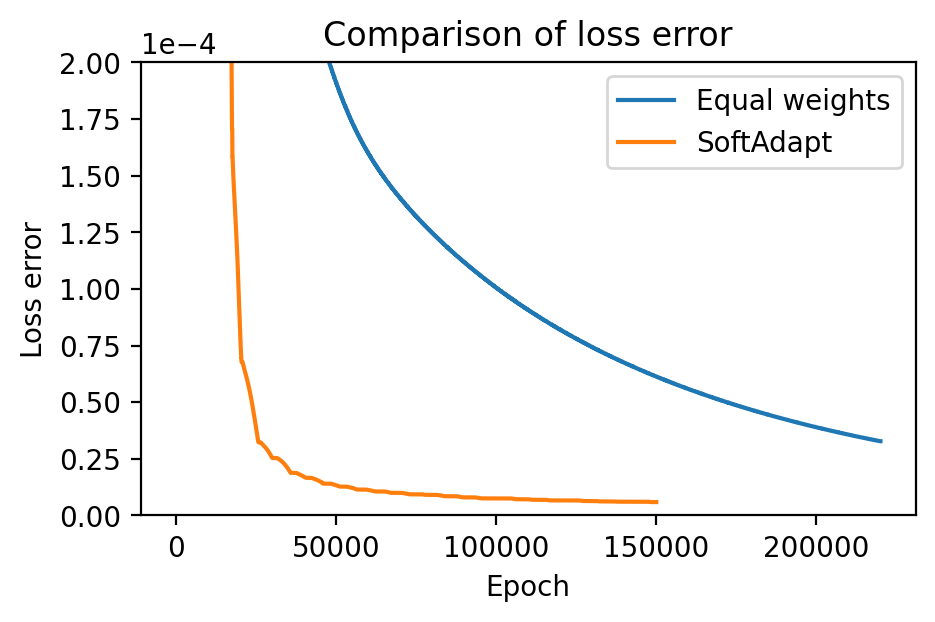

In [50]:
def select_decreasing(loss_vec):
    decr = [loss_vec[0]]
    lowest_val = loss_vec[0]
    for loss_val in loss_vec[1:]:
        if (loss_val <= lowest_val):
            decr.append(loss_val)
            lowest_val = loss_val
        else:
            decr.append(decr[-1])
    return np.array(decr)

soft_losses = net_softadapt.true_loss_values.sum(axis=1)
no_soft_losses = net.true_loss_values.sum(axis=1)

soft_loss_decr = select_decreasing(soft_losses)
no_soft_loss_decr = select_decreasing(no_soft_losses)

fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,3))
ax.plot(no_soft_loss_decr, label='Equal weights')
ax.plot(soft_loss_decr, label='SoftAdapt')
plt.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss error')
ax.set_ylim([0,0.0002])  
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_title('Comparison of loss error')
plt.savefig('figures/softadapt_loss'+ fig_save_name + '.png'
            ,format='png',bbox_inches='tight')


### Show weights

C:\Users\willi\AppData\Local\Temp\ipykernel_14024\211715660.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('figures/softadapt_lambda'+ fig_save_name + '.png'
C:\Users\willi\anaconda3\envs\pinn2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


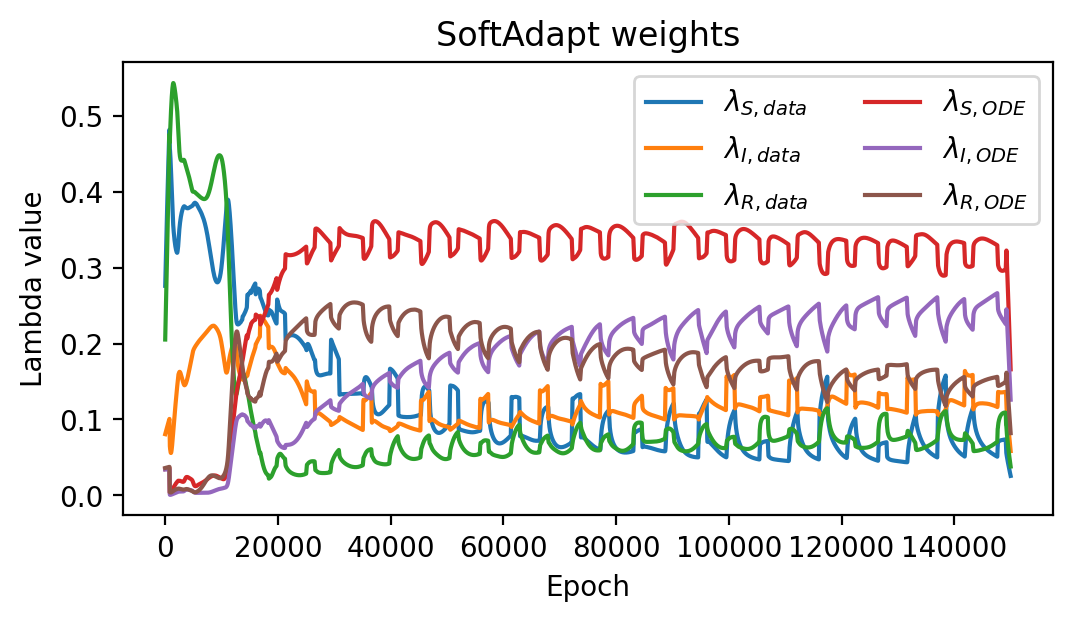

In [56]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

labels=['$\lambda_{S,data}$','$\lambda_{I,data}$','$\lambda_{R,data}$','$\lambda_{S,ODE}$','$\lambda_{I,ODE}$','$\lambda_{R,ODE}$']

lambda_values = net_softadapt.lambda_values #[0:,:]
fig, ax = plt.subplots(dpi=200, figsize=(6,3))
for label, lambd in zip(labels, lambda_values.T):
    ax.plot(smooth(lambd,1500), label=label)

ax.legend(ncol=2)
ax.set_title('SoftAdapt weights')
ax.set_ylabel('Lambda value')
ax.set_xlabel('Epoch')
plt.savefig('figures/softadapt_lambda'+ fig_save_name + '.png'
        ,format='png',bbox_inches='tight')


### Show results

219897 0.1952771246433258 0.0994868203997612
95385 0.19737043976783752 0.09847629070281982


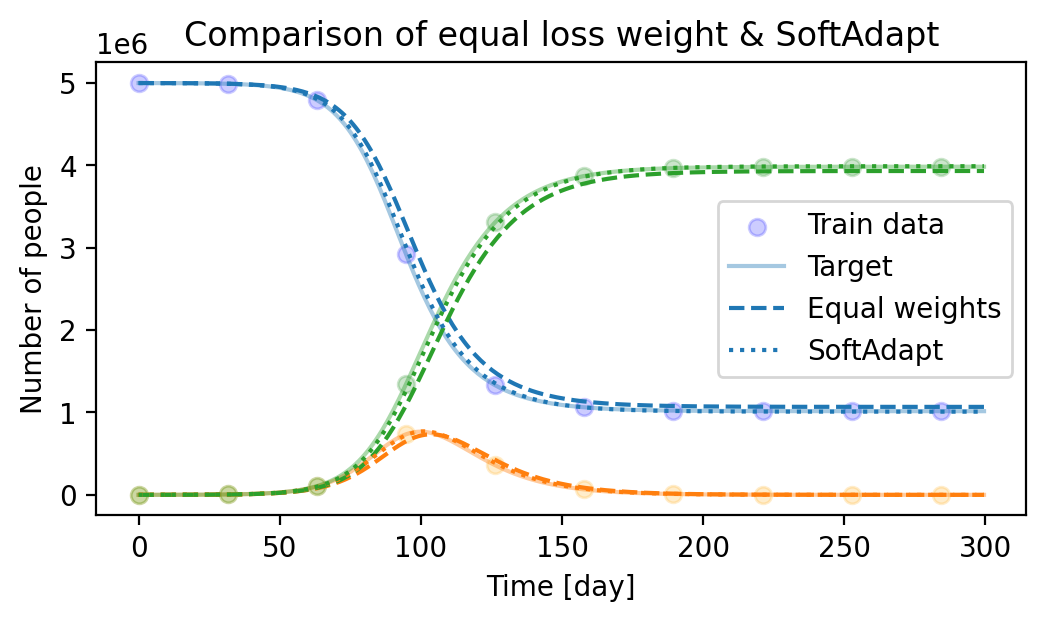

In [57]:
fig, ax = plt.subplots(figsize=(6,3),dpi=200)
alpha_circ=0.2
alpha=0.4
ax.scatter(t, wsol[:,0], color='blue', label='Train data', alpha=alpha_circ)
ax.scatter(t, wsol[:,1], color='orange', alpha=alpha_circ)
ax.scatter(t, wsol[:,2], color='green', alpha=alpha_circ)

t_est_param, wsol_est_param, N = solver.solve_SIRD(s)

t_est_param, wsol_est_param = t_est_param[(t_est_param<300)], wsol_est_param[(t_est_param<300)]

ax.plot(t_est_param, wsol_est_param[:,0], color='C0', label='Target', alpha=alpha)
ax.plot(t_est_param, wsol_est_param[:,1], color='C1', alpha=alpha)
ax.plot(t_est_param, wsol_est_param[:,2], color='C2', alpha=alpha)

for net_, ls, label in zip([net, net_softadapt], ['--',':'],['Equal weights', 'SoftAdapt']):
    losses = np.array([x.detach() for x in net_.losses])
    min_loss_idx = np.argmin(losses)

    alpha = net_.param_values['alpha'][min_loss_idx]
    beta = net_.param_values['beta'][min_loss_idx]

    print(min_loss_idx, alpha, beta)

    s_new = {'S':s['S'],
              'I':s['I'],
             'R':0,
             'alpha':alpha,
             'beta':beta}

    t_est_param, wsol_est_param, N = solver.solve_SIRD(s_new)
    t_est_param, wsol_est_param = t_est_param[(t_est_param<300)], wsol_est_param[(t_est_param<300)]

    ax.plot(t_est_param, wsol_est_param[:,0], linestyle=ls, color='C0', label=label)
    ax.plot(t_est_param, wsol_est_param[:,1], linestyle=ls, color='C1')
    ax.plot(t_est_param, wsol_est_param[:,2], linestyle=ls, color='C2')
    ax.set_title('Comparison of equal loss weight & SoftAdapt')
    
ax.legend()
ax.set_xlabel('Time [day]')
ax.set_ylabel('Number of people')
plt.savefig('figures/softadapt_result'+ fig_save_name + '.png'
        ,format='png',bbox_inches='tight')